# VBF exploration

This notebook opens a VBF root file, and looks at the deltaR(gen Higgs, jet) for:
- the selected candidate AK8 jet (closest to lepton)
- the leading AK8 jet
for both the electron and muon channels.

In [140]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [59]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
            "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

## Load the VBF merged root files

In [72]:
# load a root file into coffea-friendly NanoAOD structure
# import uproot
# f = uproot.open(f"VBF/vbf_1.root")
# f = uproot.open(f"VBF/sig.root")
# num = f['Events'].num_entries   ### checks number of events per file 
# print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root("VBF/vbf_merged.root", "Events", schemaclass=nanoevents.PFNanoAODSchema).events()

# nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

In [73]:
### the point of this block is to get the candidate_fj and the leading_fj for further studies

nevents = len(events)

# define tau objects for starters (will be needed in the end to avoid picking taus)
loose_taus_mu = (
    (events.Tau.pt > 20)
    & (abs(events.Tau.eta) < 2.3)
    & (events.Tau.idAntiMu >= 1)  # loose antiMu ID
)
loose_taus_ele = (
    (events.Tau.pt > 20)
    & (abs(events.Tau.eta) < 2.3)
    & (events.Tau.idAntiEleDeadECal >= 2)  # loose Anti-electron MVA discriminator V6 (2018) ?
)
n_loose_taus_mu = ak.sum(loose_taus_mu, axis=1)
n_loose_taus_ele = ak.sum(loose_taus_ele, axis=1)

# Object definitions:
# define muon objects
loose_muons = (
    (((events.Muon.pt > 30) & (events.Muon.pfRelIso04_all < 0.25)) |
     (events.Muon.pt > 55))
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (events.Muon.pt > 30)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# define electron objects
loose_electrons = (
    (((events.Electron.pt > 38) & (events.Electron.pfRelIso03_all < 0.25)) |
     (events.Electron.pt > 120))
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= events.Electron.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (events.Electron.pt > 38)
    & (np.abs(events.Electron.eta) < 2.4)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# get candidate lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)    # concat muons and electrons
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]      # sort by pt
candidatelep = ak.firsts(goodleptons)   # pick highest pt

candidatelep_p4 = build_p4(candidatelep)    # build p4 for candidate lepton
lep_reliso = candidatelep.pfRelIso04_all if hasattr(candidatelep, "pfRelIso04_all") else candidatelep.pfRelIso03_all    # reliso for candidate lepton
lep_miso = candidatelep.miniPFRelIso_all    # miniso for candidate lepton
mu_mvaId = candidatelep.mvaId if hasattr(candidatelep, "mvaId") else np.zeros(nevents)      # MVA-ID for candidate lepton

# JETS
goodjets = events.Jet[
    (events.Jet.pt > 30)
    & (abs(events.Jet.eta) < 5.0)
    & events.Jet.isTight
    & (events.Jet.puId > 0)
]
# reject EE noisy jets for 2017
goodjets = goodjets[
    (goodjets.pt > 50)
    | (abs(goodjets.eta) < 2.65)
    | (abs(goodjets.eta) > 3.139)
]
ht = ak.sum(goodjets.pt, axis=1)

# FATJETS
fatjets = events.FatJet

good_fatjets = (
    (fatjets.pt > 200)
    & (abs(fatjets.eta) < 2.5)
    & fatjets.isTight
)
n_fatjets = ak.sum(good_fatjets, axis=1)

good_fatjets = fatjets[good_fatjets]        # select good fatjets
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]       # sort them by pt
leading_fj = ak.firsts(good_fatjets)

# for leptonic channel: first clean jets and leptons by removing overlap, then pick candidate_fj closest to the lepton
lep_in_fj_overlap_bool = good_fatjets.delta_r(candidatelep_p4) > 0.1
good_fatjets = good_fatjets[lep_in_fj_overlap_bool]
fj_idx_lep = ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)
candidatefj_lep = ak.firsts(good_fatjets[fj_idx_lep])

In [206]:
### the point of this block is to get the matched higgs to the jet

def getParticles(genparticles, lowid=22, highid=25, flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id,
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWW(genparticles, candidatefj):
    """
    return the number of matched objects (hWW*),daughters,
    and gen flavor (enuqq, munuqq, taunuqq)
    """
    higgs = getParticles(genparticles, 25)   # genparticles is the full set... this function selects Higgs particles    
    is_hWW = ak.all(abs(higgs.children.pdgId) == 24, axis=2)    # W~24 so we get H->WW (limitation: only picking one W and assumes the other will be there)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass, axis=2, keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass, axis=2, keepdims=True)]

    prompt_electron = getParticles(genparticles, 11, 11, ['isPrompt', 'isLastCopy'])    # isPrompt avoids displaced leptons
    prompt_muon = getParticles(genparticles, 13, 13, ['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles, 15, 15, ['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles, 0, 5, ['fromHardProcess', 'isLastCopy'])      # 0-5 not 0-6 to avoid top quark
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]       # parent W

    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks, dr_fj_electrons, dr_fj_muons, dr_fj_taus], axis=1)
    hWW_nprongs = ak.sum(dr_daughters < 0.8, axis=1)   # impose that something must be inside the cone... tells you # of particles from Higgs matched to the jet

    n_electrons = ak.sum(prompt_electron.pt > 0, axis=1)
    n_muons = ak.sum(prompt_muon.pt > 0, axis=1)
    n_taus = ak.sum(prompt_tau.pt > 0, axis=1)
    n_quarks = ak.sum(prompt_q.pt > 0, axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWW_flavor = (n_quarks == 2) * 1 + (n_electrons == 1) * 3 + (n_muons == 1) * 5 + (n_taus == 1) * 7 + (n_quarks == 4) * 11

    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)    # choose higgs closest to fj
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)  # choose W closest to fj
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8)  # choose Wstar closest to fj

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWW_matched = (
        (ak.sum(matchedH.pt > 0, axis=1) == 1) * 1
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1) == 1) * 3
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1) == 1) * 5
    )

    # leptons matched
    dr_fj_leptons = ak.concatenate([dr_fj_electrons, dr_fj_muons], axis=1)

    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[dr_fj_leptons < 0.8]

    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)   # # TODO: why need firsts
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = (leptons_mass == higgs_w_mass)
    iswstarlepton = (leptons_mass == higgs_wstar_mass)

    ret = {"hWW_flavor": hWW_flavor,
           "hWW_matched": hWW_matched,
           "hWW_nprongs": hWW_nprongs,
           "matchedH": matchedH,
           "iswlepton": iswlepton,  # truth info, higher mass is normally onshell
           "iswstarlepton": iswstarlepton}  # truth info, lower mass is normally offshell

    return ret

## Without higgs.pt>200 sleection

In [236]:
# match the higgs to both candidate_fj and leading_fj

match_H_candidate = match_HWW(events.GenPart, candidatefj_lep)
match_H_leading = match_HWW(events.GenPart, leading_fj)

In [237]:
# get dr between matched higgs to candidate_fj

dr_candidate = candidatefj_lep.delta_r(match_H_candidate['matchedH'])
dr_candidate = ak.flatten(dr_candidate)[~ak.is_none(ak.flatten(dr_candidate))]
dr_candidate = ak.to_numpy(dr_candidate).data
dr_candidate

array([0.03930607, 0.29378492, 0.01584894, ..., 0.11623658, 0.02275228,
       0.14870034], dtype=float32)

In [238]:
# get dr between matched higgs to leading_fj

dr_leading = leading_fj.delta_r(match_H_leading['matchedH'])
dr_leading = ak.flatten(dr_leading)[~ak.is_none(ak.flatten(dr_leading))]
dr_leading = ak.to_numpy(dr_leading).data
dr_leading

array([0.24703906, 0.23594214, 0.15166739, ..., 0.13232511, 0.02275228,
       0.14870034], dtype=float32)

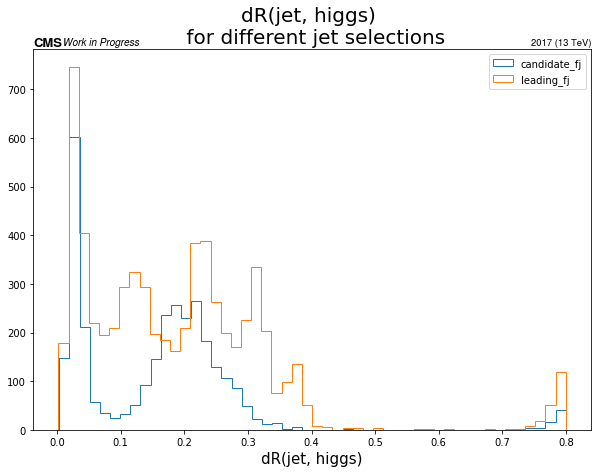

In [239]:
year = '2017'
fig, ax = plt.subplots(figsize=(10, 7))

dic = {'candidate_fj': dr_candidate,
      'leading_fj': dr_leading}

# make plots per channel
for key, val in dic.items():
    plt.hist(val, 
             bins=50, 
             label=key, 
#                      density=True,
             histtype='step',)

ax.legend()
ax.set_xlabel(f"dR(jet, higgs)", fontsize=15)
ax.set_title(f'dR(jet, higgs) \n for different jet selections', fontsize=20)
# ax.set_xlim(0,1000)
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
# plt.close()
#     break

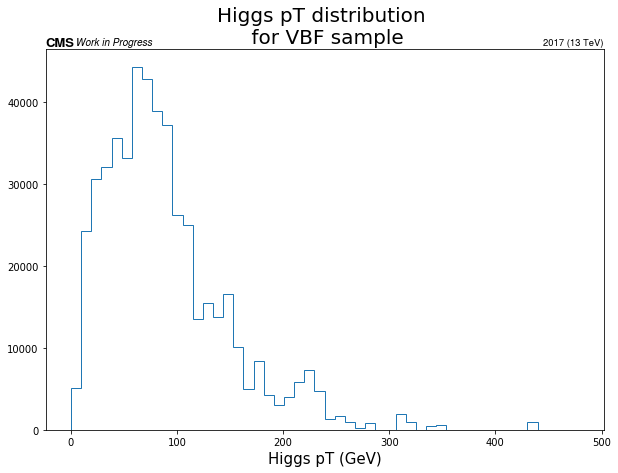

In [240]:
# Higgs pT distribution
year = '2017'
higgs = getParticles(events.GenPart, 25)

fig, ax = plt.subplots(figsize=(10, 7))

dic = {'candidate_fj': dr_candidate,
      'leading_fj': dr_leading}

# make plots per channel
plt.hist(higgs.pt, 
         bins=50, 
#                      density=True,
         histtype='step',)

ax.set_xlabel(f"Higgs pT (GeV)", fontsize=15)
ax.set_title(f'Higgs pT distribution \n for VBF sample', fontsize=20)
# ax.set_xlim(0,1000)
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
# plt.close()
#     break

In [244]:
# this block attempts to get the dr(jet, lepton) for jet ~ [candidate_fj, leading_fj] and lepton ~ [ele, mu]

# get dR between ele and different jet selections
dr_leading_ele = leading_fj.delta_r(events.Electron)
dr_leading_ele = ak.flatten(dr_leading_ele)[~ak.is_none(ak.flatten(dr_leading_ele))]
# dr_leading_ele = ak.to_numpy(dr_leading_ele).data
print('dr_leading_ele', dr_leading_ele)

dr_candidate_ele = candidatefj_lep.delta_r(events.Electron)
dr_candidate_ele = ak.flatten(dr_candidate_ele)[~ak.is_none(ak.flatten(dr_candidate_ele))]
# dr_candidate_ele = ak.to_numpy(dr_candidate_ele).data
print('dr_candidate_ele', dr_candidate_ele)

print('-------------------------------------------------------------------------------')
# get dR between mu and different jet selections
dr_leading_mu = leading_fj.delta_r(events.Muon)
dr_leading_mu = ak.flatten(dr_leading_mu)[~ak.is_none(ak.flatten(dr_leading_mu))]
# dr_leading_mu = ak.to_numpy(dr_leading_mu).data
print('dr_leading_mu', dr_leading_mu)

dr_candidate_mu = candidatefj_lep.delta_r(events.Muon)
dr_candidate_mu = ak.flatten(dr_candidate_mu)[~ak.is_none(ak.flatten(dr_candidate_mu))]
# dr_candidate_mu = ak.to_numpy(dr_candidate_mu).data
print('dr_candidate_mu', dr_candidate_mu)

dr_leading_ele [3.42, 3.55, 0.0148, 0.255, 0.0169, 3.28, ... 3.36, 3.46, 3.67, 3.6, 3.29, 3.02]
dr_candidate_ele [0.0169, 3.28, 3.18, 3.35, 3.46, 0.941, ... 0.284, 0.34, 0.204, 3.54, 3.16, 0.21]
-------------------------------------------------------------------------------
dr_leading_mu [2.68, 0.0792, 2.88, 1.68, 1.61, 0.741, ... 4.27, 3.79, 0.188, 3.23, 3.24, 1.98]
dr_candidate_mu [2.88, 2.79, 0.323, 0.136, 0.875, 3.58, ... 0.342, 0.376, 0.323, 0.188, 3.23, 3.24]


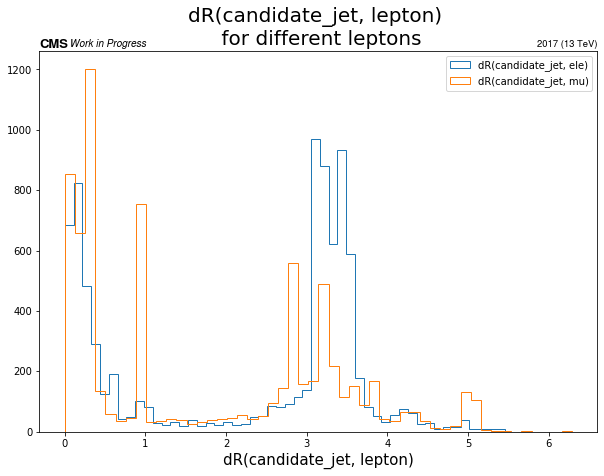

In [249]:
# note: without higgs.pt>200 selection
year = '2017'
fig, ax = plt.subplots(figsize=(10, 7))

dic = {'dR(candidate_jet, ele)': dr_candidate_ele,
      'dR(candidate_jet, mu)': dr_candidate_mu}

# make plots per channel
for key, val in dic.items():
    plt.hist(val, 
             bins=50, 
             label=key, 
#                      density=True,
             histtype='step',)

ax.legend()
ax.set_xlabel(f"dR(candidate_jet, lepton)", fontsize=15)
ax.set_title(f'dR(candidate_jet, lepton) \n for different leptons', fontsize=20)
# ax.set_xlim(0,1000)
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
# plt.close()
#     break

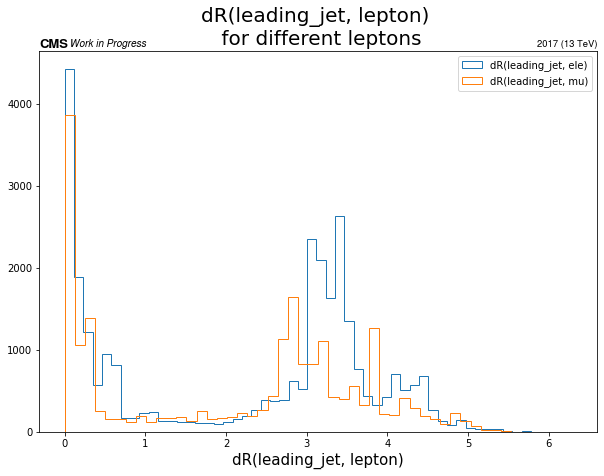

In [250]:
# note: without higgs.pt>200 selection
year = '2017'
fig, ax = plt.subplots(figsize=(10, 7))

dic = {'dR(leading_jet, ele)': dr_leading_ele,
      'dR(leading_jet, mu)': dr_leading_mu}

# make plots per channel
for key, val in dic.items():
    plt.hist(val, 
             bins=50, 
             label=key, 
#                      density=True,
             histtype='step',)

ax.legend()
ax.set_xlabel(f"dR(leading_jet, lepton)", fontsize=15)
ax.set_title(f'dR(leading_jet, lepton) \n for different leptons', fontsize=20)
# ax.set_xlim(0,1000)
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
# plt.close()
#     break

## With higgs.pt>200 sleection

In [245]:
# not sure if i should first do selection then match or match then apply selection

# match_H_candidate = match_HWW(events.GenPart, candidatefj_lep)
# match_H_leading = match_HWW(events.GenPart, leading_fj)

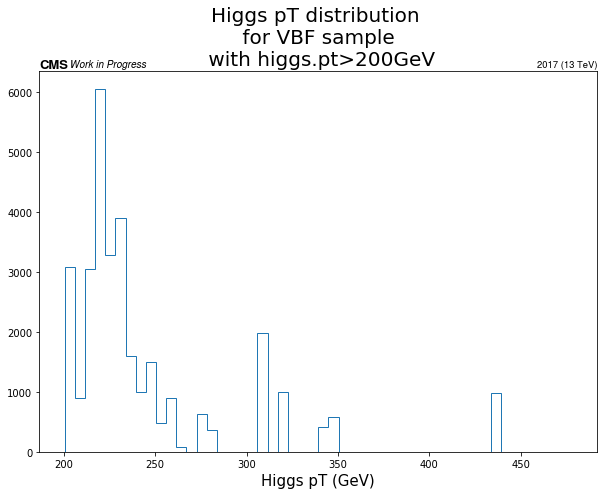

In [235]:
# Higgs pT distribution with higgs.pt>200
year = '2017'
fig, ax = plt.subplots(figsize=(10, 7))

dic = {'candidate_fj': dr_candidate,
      'leading_fj': dr_leading}

# make plots per channel
plt.hist(ak.flatten(higgs[higgs.pt>200]).pt, 
         bins=50, 
#                      density=True,
         histtype='step',)

ax.set_xlabel(f"Higgs pT (GeV)", fontsize=15)
ax.set_title(f'Higgs pT distribution \n for VBF sample \n with higgs.pt>200GeV', fontsize=20)
# ax.set_xlim(0,1000)
hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig(f'/Users/fmokhtar/Desktop/plots/{ch}_gen_HpTplots.pdf')
# plt.close()
#     break